In [1]:
import sys
sys.path.append('./pyuid3')

In [69]:
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
from anchor import utils
from anchor import anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from pyuid3.uncertain_entropy_evaluator import UncertainEntropyEvaluator
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [70]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Make moons

In [71]:
X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
#Xa,ya = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                    #random_state=0, center_box=(-0.8,0))
#Xb,yb = sklearn.datasets.make_blobs(n_samples=100, centers=1,cluster_std=0.2, n_features=2,
                                   # random_state=0, center_box=(-3.5,3.3))

#X = np.vstack((X,Xa,Xb))
#y = np.hstack((y,ya,yb+1))

Xdf = pd.DataFrame(X, columns=['x1','x2'])

In [72]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['x1','x2']
X_test.columns = ['x1','x2']

<AxesSubplot:xlabel='x1', ylabel='x2'>

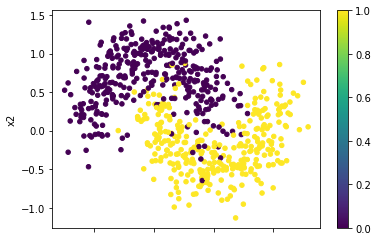

In [73]:
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis')

In [74]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       153
           1       0.91      0.94      0.93       177

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



In [92]:
from sklearn.linear_model import LogisticRegression
xclf = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
xclf.fit(X_train, y_train)
lr_preds = xclf.predict(X_test)

In [93]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.9333333333333333
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       153
           1       0.94      0.94      0.94       177

    accuracy                           0.93       330
   macro avg       0.93      0.93      0.93       330
weighted avg       0.93      0.93      0.93       330



<AxesSubplot:xlabel='x1', ylabel='x2'>

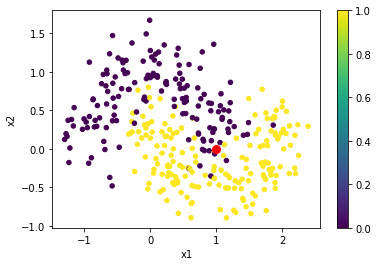

In [94]:
fig, ax = plt.subplots()
point = [1.0,0.0]
ax.plot(point[0], point[1], 'or', markersize=8)
X_test.plot(kind='scatter',x='x1', y='x2', c=y_test, colormap='viridis', ax=ax)

In [95]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['x1','x2']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

## Decision Boundaries

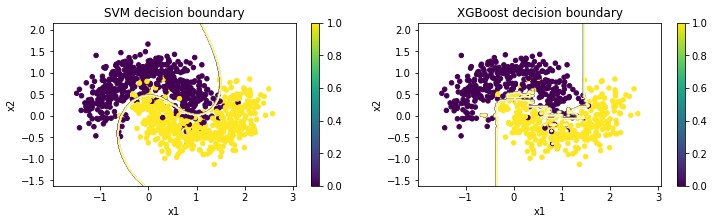

In [96]:

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
Xdf.plot(kind='scatter',x='x1', y='x2',style='.', c=y, colormap='viridis',ax=ax[0])

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
X_train.plot(kind='scatter',x='x1', y='x2',style='.', c=y_train, colormap='viridis',ax=ax[1])
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')
fig.savefig('dataset.png')

## Confidence plots

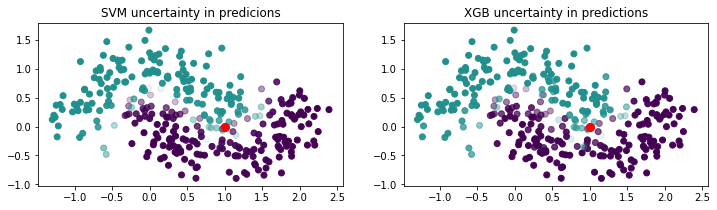

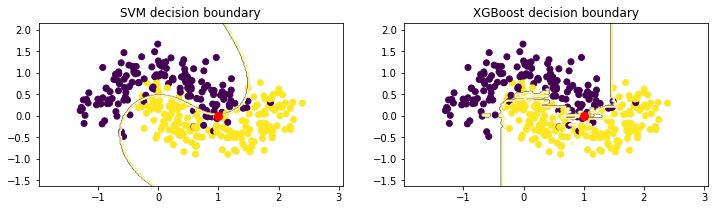

In [97]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = svc.predict_proba(X_test_appended)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = xclf.predict_proba(X_test_appended)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test_appended.iloc[y_test_appended==1]
X_test_2 = X_test_appended.iloc[y_test_appended==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_svc.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=confidence_xgb.iloc[y_test_appended==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_xgb.iloc[y_test_appended==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)


fig.savefig('uncertainty-point.png')

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_test['x1'], X_test['x2'], c=y_test, cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
fig.savefig('decbound-point.png')
plt.show()

## LUX explanations

In [98]:
from lux.lux import LUX

In [99]:
point = [0,1]
clf = xclf

lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(X_train, y_train,np.array([point]),X_importances = None, exclude_neighbourhood=False, use_parity=True, inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=True, representative='centroid')

Setting radius to [1420.17889858]
Farthest point: [3076.12592235]


In [100]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE,ADASYN,SVMSMOTE

In [101]:
def outliers(data,multiplier=1.5):
    # finding the 1st quartile
    q1 = np.quantile(data, 0.25)

    # finding the 3rd quartile
    q3 = np.quantile(data, 0.75)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(multiplier*iqr)
    lower_bound = q1-(multiplier*iqr)
    return (iqr, upper_bound, lower_bound)

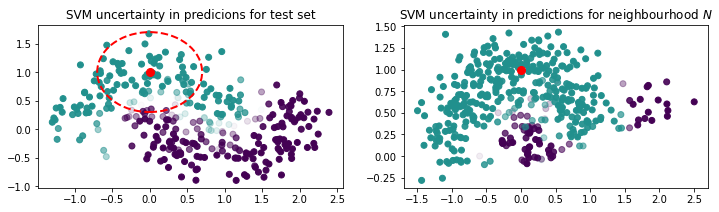

In [102]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood.png')

In [103]:
import warnings
warnings.filterwarnings('ignore')
#for i in np.arange(10):
for c in np.unique(y_train):
    X_train_input_c  = X_train_sample.loc[clf.predict(X_train_sample) ==c]
    prediction_certainty = np.max(clf.predict_proba(X_train_input_c), axis=1)
    #_,_,confidence_threshold = outliers(prediction_certainty,multiplier=1.5)
    confidence_threshold = np.mean(prediction_certainty)-np.std(prediction_certainty)
    X_train_input = X_train_input_c[prediction_certainty<confidence_threshold]
    predictions = clf.predict(X_train_sample)
    unique, counts = np.unique(predictions, return_counts=True)
    try:
        sm = BorderlineSMOTE(random_state=42)#,k_neighbors=min(5,min(counts)))#,m_neighbors=min(min(counts),10))
        X_train_input = pd.concat([X_train_input, X_train_sample[clf.predict(X_train_sample) !=c]])
        X_input_c,_ = sm.fit_resample(X_train_input, clf.predict(X_train_input))
        concatdf = pd.concat((X_input_c, X_train_sample))
        X_train_sample =concatdf.loc[~concatdf.duplicated()]
    except:
        print('Error')
        pass


## Neighbourhood plotting

In [104]:
sm = SMOTE(random_state=42)
X_train_sample,_ = sm.fit_resample(X_train_sample, clf.predict(X_train_sample))

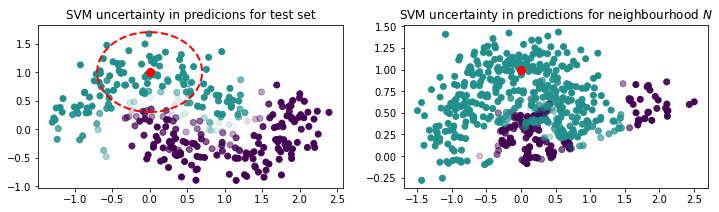

In [105]:
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = clf.predict_proba(X_train_sample)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))


y_test_proba_o = clf.predict_proba(X_test_appended)
confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba_o[:,0], 
                                                                             'SVC_1':y_test_proba_o[:,1]})))

y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
X_test_1_o.columns=['x1','x2']

X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1_o['x1'], X_test_1_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2_o['x1'], X_test_2_o['x2'], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions for test set')

#rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
rect = patches.Circle(tuple(point),0.7,ec='r', fc="None", ls='--', linewidth=2)

ax[0].add_patch(rect)


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='SVM uncertainty in predictions for neighbourhood $N$')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)

fig.savefig('neighbourhood2.png')

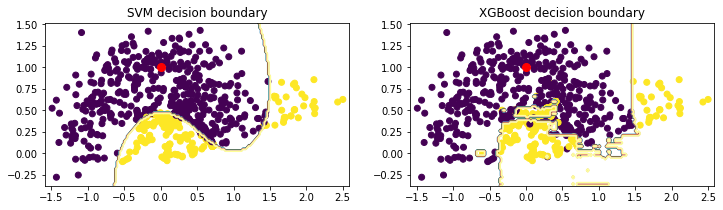

In [106]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_train_sample.values[:, 0].min() - 0.1, X_train_sample.values[:, 0].max() + 0.1
y_min, y_max = X_train_sample.values[:, 1].min() - 0.1, X_train_sample.values[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = xclf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1','x2']))


# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig,ax= plt.subplots(1,2, figsize=(12,3))
ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
ax[0].scatter(X_train_sample['x1'], X_train_sample['x2'], c=svc.predict(X_train_sample), cmap='viridis')

ZZ = ZZ.reshape(xx.shape)
ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
ax[1].scatter(X_train_sample['x1'], X_train_sample['x2'], c=clf.predict(X_train_sample), cmap='viridis')
ax[0].set(title='SVM decision boundary')
ax[1].set(title='XGBoost decision boundary')

ax[0].plot(point[0], point[1], 'or', markersize=8)
ax[1].plot(point[0], point[1], 'or', markersize=8)
plt.show()

In [107]:
X_train_sample.shape

(998, 2)

In [179]:
clfgb = xgb.XGBClassifier(eval_metric='error')
clfgb.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [180]:
explainer = shap.Explainer(clfgb, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [183]:
shap_values[0]
explainer.expected_value

0.5411494003225481

In [108]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf, X_train_sample,model_output='probability')
shap_values = explainer.shap_values(X_train_sample,check_additivity=True)

In [111]:
shap_values

[array([[-0.15845   , -0.08185   ],
        [-0.137     , -0.1033    ],
        [-0.06995   , -0.15035   ],
        ...,
        [-0.66809999,  0.1378    ],
        [-0.12035   , -0.09995   ],
        [-0.0148    , -0.46549999]]),
 array([[ 0.15845   ,  0.08185   ],
        [ 0.137     ,  0.1033    ],
        [ 0.06995   ,  0.15035   ],
        ...,
        [ 0.66809999, -0.1378    ],
        [ 0.12035   ,  0.09995   ],
        [ 0.0148    ,  0.46549999]])]

In [118]:
X_train_sample

,x1,x2
0,-0.121912,0.515923
1,0.517236,0.873584
2,-0.326258,0.500804
3,0.416166,0.605743
4,-0.595121,0.000899
...,...,...
993,0.282903,0.523866
994,0.406007,0.067832
995,2.430894,0.596428
996,0.346144,0.433413


In [113]:
uarff=LUX.generate_uarff(X_train_sample,clf.predict_proba(X_train_sample), X_importances=None,class_names=[0,1])
data = Data.parse_uarff_from_string(uarff)

In [115]:
datadf = data.to_dataframe()
shap_dict={}
expected_dict={}
expected_values = explainer.expected_value
for i,v in enumerate(shap_values):
    shap_dict[str(i)] = pd.DataFrame(v, columns = datadf.columns[:-1])
    expected_dict[str(i)] = expected_values[i]

data = data.set_importances(pd.concat(shap_dict,axis=1), expected_values = expected_dict)

In [126]:
data.instances[-1].get_reading_for_attribute('x2').get_most_probable().get_importances()

{'0': -0.4654999895952642, '1': 0.4654999895952642}

In [145]:
def get_maximum_label(shapdict):
            return max(shapdict, key=shapdict.get)
        
labels = [get_maximum_label(i.get_reading_for_attribute('x2').get_most_probable().get_importances()) for i in data.instances]

In [146]:
expected_values

array([0.5603, 0.4397])

In [147]:
tlabels = clf.predict(datadf.iloc[:,:-1])

In [148]:
ilabels = [int(i) for i in labels]

In [149]:
(tlabels==ilabels).sum()/len(labels)

0.7364729458917836

In [150]:
np.where(tlabels==ilabels)

(array([  0,   4,   5,   7,   9,  10,  11,  13,  15,  16,  17,  18,  19,
         21,  23,  25,  26,  27,  28,  31,  32,  33,  34,  36,  37,  38,
         39,  40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  55,  56,  57,  58,  60,  61,  62,  63,  65,  67,  68,  70,
         73,  75,  76,  77,  78,  79,  81,  84,  85,  86,  87,  88,  89,
         90,  92,  93,  94,  95,  96,  97,  98,  99, 101, 102, 103, 104,
        105, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 128, 129, 131, 132, 133, 137, 138, 139,
        140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155,
        156, 157, 160, 161, 162, 163, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 190, 192, 194, 195, 196, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227

In [151]:
labelsx1 = [get_maximum_label(i.get_reading_for_attribute('x1').get_most_probable().get_importances()) for i in data.instances]

In [156]:
ilabelsx1 = [int(i) for i in labelsx1]
(tlabels==ilabelsx1).sum()/len(labels)

0.7474949899799599

In [158]:
stats = data.calculate_statistics(data.get_attribute_of_name('x1'))

In [160]:
stats.get_avg_abs_importance()

353.1816921057734

In [168]:
sum(abs(shap_values[0][:,0]))/len(shap_values[0])*2

0.3538894710478691

In [167]:
sum(abs(shap_values[1][:,1]))/len(shap_values[0])

0.19644693949684405

In [220]:
nn=NearestNeighbors(n_neighbors=1)

In [221]:
nn.fit(X_train)

NearestNeighbors(n_neighbors=1)

In [222]:
X_train.iloc[0,:]

x1    0.018920
x2    0.342626
Name: 703, dtype: float64

In [223]:
r,i = nn.kneighbors(X_train.iloc[0,:].values.reshape(1,-1))

In [228]:
i.ravel()[0]

0

In [225]:
i[0,1]

IndexError: index 1 is out of bounds for axis 1 with size 1

In [213]:
i

array([[  0, 349, 366, 461, 427, 152, 528, 431, 655, 131]])